## 剛剛那個爆炸了

In [21]:
# modular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from time import perf_counter as clock # 記錄程式時間戳記
from pathlib import Path # 高級路徑工具
from urllib import request # 抓網路資料的

from ppxf.ppxf import ppxf
from ppxf.ppxf_util import log_rebin
import ppxf.ppxf_util as util
#import ppxf.sps_util as lib 

### Setup MUSE data
因為和老哥用的不是同一個儀器的數據  
所以我在這邊要死要活的

In [ ]:
# 
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
file_path = "/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV)
muse_header = muse_hdul['DATA'].header

Filename: /Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1341   ()      
  1  DATA          1 ImageHDU        43   (317, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (317, 319, 3682)   float32   


#### Make WL & spec axis
 製作波長軸以及光譜軸  

In [12]:
# original AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# original spectrum intensity axis (flux)
print(f"Original WAV axis's shape = {ori_lamb.shape}")
i, j = muse_data.shape[1]//2, muse_data.shape[2]//2 # certain pixel, 之後應該是要 gothrogh 的
ori_flux_unnorm = muse_data[:, i, j]
if ori_flux_unnorm.shape==ori_lamb.shape : # 他媽的這本來就要一樣吧
    print('Nice ^_-!')

Original WAV axis's shape = (3682,)
Nice ^_-!


#### Futher processing of that two axis
- 對數、真空和air  
- 正規化、考慮噪音

Velocity resolu(?) on ln-WAV axis (km/s) = 55.17

Log wL (ln, air): [4750.1079174  4750.98207595 4751.85639537 ... 9347.86960246 9349.58988341
 9351.31048094]
Transfered wL (ln, vaccum): [4748.79658718 4749.67050441 4750.54458247 ... 9345.28899923 9347.00880527
 9348.72892781]
Ori wL (linear, air): [4750.29589844 4751.54589844 4752.79589844 ... 9349.04589844 9350.29589844
 9351.54589844]


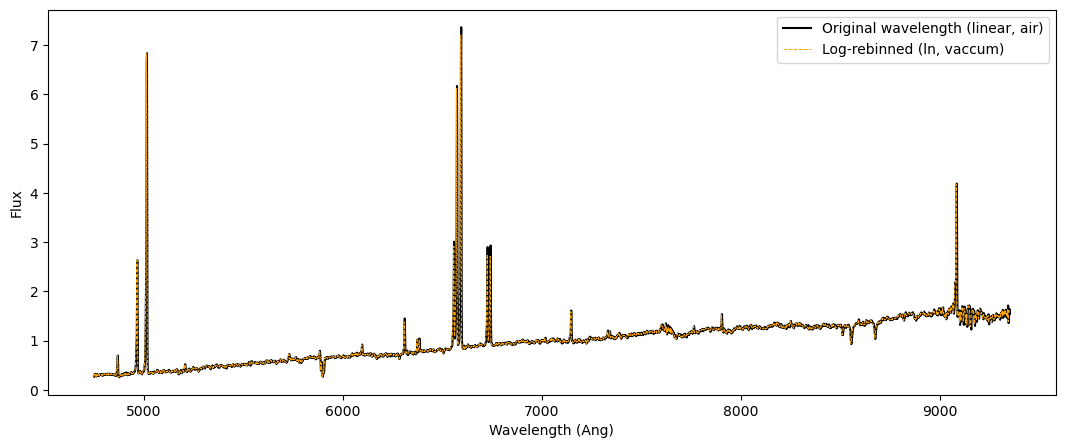

In [ ]:
# flux normalization
def flux_Norm(flux): # 除到 nan 中位數的話，就會爆炸，所以做了這個
    flux_no_nan = flux[~np.isnan(flux)]
    if len(flux_no_nan) > 10 and np.nanmedian(flux_no_nan) != 0:
        return flux / np.nanmedian(flux_no_nan)
    else:
        return flux

ori_flux = flux_Norm(ori_flux_unnorm) # 沒標 un- 就是正規化了

# consider noise
noise = np.full_like(ori_flux, 0.0149)

# Log(ln) waveLen array
ln_flux, ln_lamb_pix, veloScale = log_rebin([ori_lamb[0], ori_lamb[-1]], ori_flux)
print(f"Velocity resolu(?) on ln-WAV axis (km/s) = {veloScale:.2f}", end='\n\n')
# veloScale 算好了喔好方便捏
ln_lamb = np.exp(ln_lamb_pix) # 從 ln(lambda) 換成 AA
print(f'Log wL (ln, air): {ln_lamb}') #

# (waveLen) air --> vaccum
# 這個要小心喔，因為我不確定他背後是怎樣運作的
ln_lamb *= np.median(util.vac_to_air(ln_lamb)/ln_lamb)
print(f'Transfered wL (ln, vaccum): {ln_lamb}') #
print(f'Ori wL (linear, air): {ori_lamb}') #

# 畫出來看看
# log-rebin 會讓高波長區 sampling 點變多、低波長變少。(by C)
plt.figure(figsize=(13, 5))
plt.plot(ori_lamb, ori_flux, c='k', label='Original wavelength (linear, air)')
plt.plot(ln_lamb, ln_flux, c='orange', lw=0.7, label='Log-rebinned (ln, vaccum)', linestyle='--') # 大便般的配色
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Flux")
plt.legend()
plt.show()


#### something ELSE

In [ ]:
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

lam_gal = lam_gal/(1 + redshift_0)      ### Compute approximate restframe wavelength
fwhm_gal = fwhm_gal/(1 + redshift_0)    # Adjust resolution in Angstroms




# (選做) 把波長軸轉到 restframe
ln_lamb_rf = ln_lamb / (1+z)

# (選做) 儀器解析度（R = lambda/dlambda）
R = 3000
fwhm_inst = ln_lamb / R  # 單位：Angstrom

## UNK

In [ ]:
temp_path = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/spectra_emiles_9.0.npz'
